<a href="https://colab.research.google.com/github/yutake27/HandWrittenCharacter/blob/master/src/metric_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Writer identification for handwritten hiragana dataset using deep metric learning

In [1]:
!git clone https://github.com/yutake27/HandWrittenCharacter.git

Cloning into 'HandWrittenCharacter'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 106 (delta 5), reused 94 (delta 2), pack-reused 0
Receiving objects: 100% (106/106), 1.23 MiB | 24.71 MiB/s, done.
Resolving deltas: 100% (5/5), done.


## Make handwritten dataset

In [2]:
from torch.utils.data import Dataset
from PIL import Image
from pathlib import Path
import pandas as pd

class HandWrittenDataset(Dataset):
    def __init__(self, img_dir, csv_path, phase='train', rate=0.8, seed=0, transform=None):
        self.img_dir = Path(img_dir)
        df = pd.read_csv(csv_path).sample(frac=1, random_state=seed).reset_index(drop=True)
        assert phase == 'train' or phase == 'test'
        self.df = self.split_df(df, phase, rate)
        self.transform = transform
      
    def split_df(self, df, phase, rate):
        df_list = []
        for name, group in df.groupby('writer_id'):
            if phase == 'train':
                df_list.append(group[: int(len(group) * rate)])
            elif phase == 'test':
                df_list.append(group[int(len(group) * rate): ])
        df = pd.concat(df_list).reset_index(drop=True)
        return df

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, i):
        file_name = self.df['Filename'][i]
        file_path = self.img_dir / file_name
        data = Image.open(file_path)
        if self.transform:
            data = self.transform(data)
        label = self.df['writer_id'][i]
        return data, label

In [3]:
from torchvision import transforms
img_size = (28, 28)
transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

In [4]:
img_dir = 'HandWrittenCharacter/Dataset'
csv_path = img_dir + '/' + 'Dataset.csv'
dataset = HandWrittenDataset(img_dir, csv_path, transform=transform)
test_dataset = HandWrittenDataset(img_dir, csv_path, phase='test', transform=transform)
import torch
train_lens = int(len(dataset) * 0.75)
val_lens = int(len(dataset) - train_lens)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_lens, val_lens])

In [5]:
print(len(train_dataset))

48


In [6]:
len(val_dataset)

16

In [7]:
len(test_dataset)

16

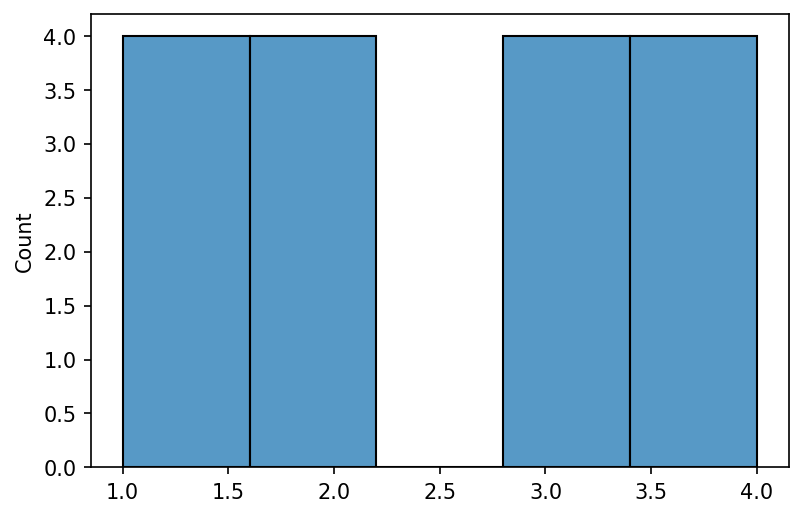

In [8]:
import matplotlib
matplotlib.rcParams['figure.dpi'] = 150
import matplotlib.pyplot as plt
import seaborn as sns
test_label_list = []
for i in range(len(test_dataset)):
    data, label = test_dataset[i]
    test_label_list.append(label)
sns.histplot(test_label_list)

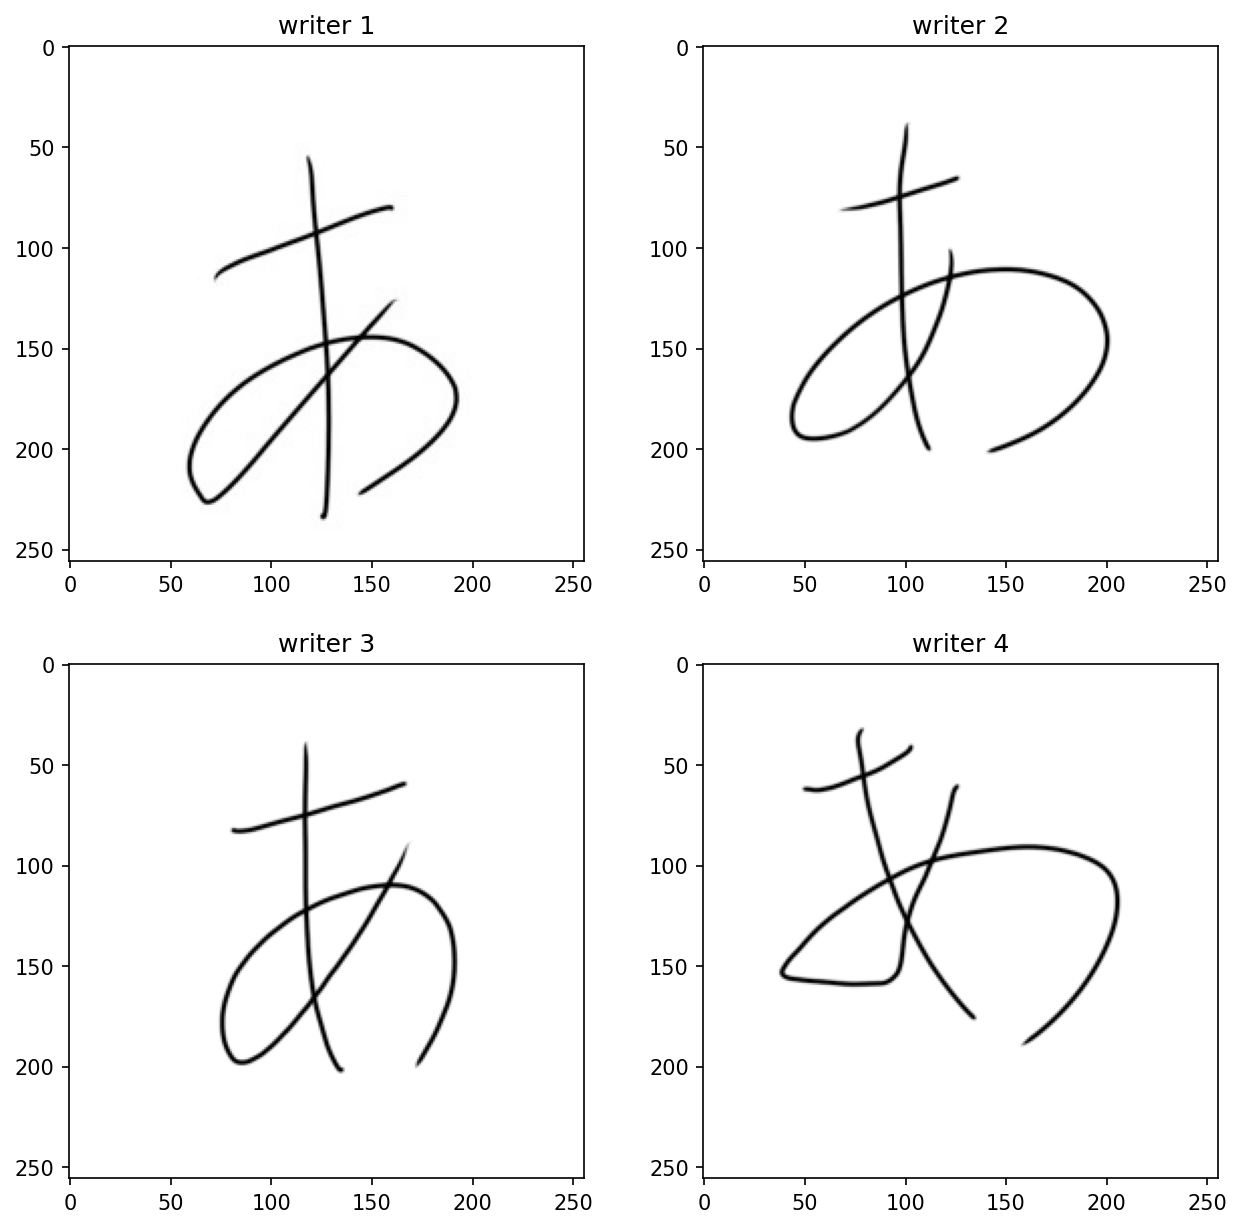

In [9]:
import matplotlib
matplotlib.rcParams['figure.dpi'] = 150
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.figure(figsize=(10, 10))
for i in range(4):
    image = Image.open(Path(img_dir) / ('U3042/U3042_000' + str(i * 2) + '1.png'))
    plt.subplot(2, 2, i + 1)
    plt.title('writer ' + str(i + 1))
    plt.imshow(np.array(image))

## make network

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

In [11]:
from torchsummary import summary
model = Net()  
summary(model.to('cuda'), (1,28,28)) # summary(model,(channels,H,W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
         Dropout2d-3           [-1, 64, 12, 12]               0
            Linear-4                  [-1, 128]       1,179,776
Total params: 1,198,592
Trainable params: 1,198,592
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.52
Params size (MB): 4.57
Estimated Total Size (MB): 5.09
----------------------------------------------------------------


In [12]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(4608, 32)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

In [13]:
model = SmallNet()  
summary(model.to('cuda'), (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
            Conv2d-2           [-1, 32, 24, 24]           4,640
         Dropout2d-3           [-1, 32, 12, 12]               0
            Linear-4                   [-1, 32]         147,488
Total params: 152,288
Trainable params: 152,288
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.26
Params size (MB): 0.58
Estimated Total Size (MB): 0.84
----------------------------------------------------------------


## Metric Learning

In [14]:
!pip install pytorch-metric-learning
!pip install faiss-gpu

     |████████████████████████████████| 102kB 4.3MB/s 
     |████████████████████████████████| 67.7MB 46kB/s 


In [15]:
from pytorch_metric_learning import losses, miners, distances, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms
import numpy as np


def train_iter(model, loss_func, mining_func, device, train_loader, optimizer, epoch):
    model.train()
    loss_list = []
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        loss.backward()
        optimizer.step()
        # if batch_idx % 1 == 0:
        #     print("Epoch {} Iteration {}: Loss = {}, Number of mined triplets = {}".format(epoch, batch_idx, loss, mining_func.num_triplets))
        loss_list.append(loss.to('cpu').detach().numpy())
    loss = np.mean(loss_list)
    print("Epoch {}: Loss = {}".format(epoch, loss))
    return loss

### convenient function from pytorch-metric-learning ###
def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)

def val_iter(model, loss_func, mining_func, device, val_loader):
    loss_list = []
    with torch.no_grad():
        for batch_idx, (data, labels) in enumerate(val_loader):
            data, labels = data.to(device), labels.to(device)
            embeddings = model(data)
            indices_tuple = mining_func(embeddings, labels)
            loss = loss_func(embeddings, labels, indices_tuple)
            loss_list.append(loss.to('cpu').detach().numpy())
    loss = np.mean(loss_list)
    print("Validation Loss = {}".format(loss))
    return loss

### compute accuracy using AccuracyCalculator from pytorch-metric-learning ###
def test_iter(train_set, test_set, model, accuracy_calculator):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    accuracies = accuracy_calculator.get_accuracy(test_embeddings, 
                                                train_embeddings,
                                                np.squeeze(test_labels),
                                                np.squeeze(train_labels),
                                                False)
    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))
    return accuracies, test_embeddings, test_labels

def output_result(train_loss_list, val_loss_list, test_accuracy_list):
    plt.figure(figsize=(6, 4))
    epoch_list = list(range(1, len(train_loss_list) + 1))
    plt.plot(epoch_list, train_loss_list, label='train')
    plt.plot(epoch_list, val_loss_list, color='orange', label='valiadtion')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    plt.plot(epoch_list, [acc['precision_at_1'] for acc in test_accuracy_list])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    min_val_loss_epoch = np.argmin(val_loss_list)
    test_acc = test_accuracy_list[min_val_loss_epoch]['precision_at_1']
    print('Validation loss is minimum in Epoch {}: Test set accuracy (precision@1) = {}'.format(min_val_loss_epoch + 1, test_acc))

device = torch.device("cuda")

img_size = (28, 28)

transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

transform_aug = transforms.Compose([
        transforms.Resize(img_size),
        transforms.Grayscale(),
        transforms.RandomRotation(degrees=5),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

seed = 7
np.random.seed(seed) 
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
train_data_rate = 0.75
img_dir = 'HandWrittenCharacter/Dataset'
csv_path = img_dir + '/' + 'Dataset.csv'
dataset = HandWrittenDataset(img_dir, csv_path, transform=transform)
test_dataset = HandWrittenDataset(img_dir, csv_path, phase='test', transform=transform)
len_train = int(len(dataset) * train_data_rate)
len_val = int(len(dataset) - len_train)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [len_train, len_val])

In [16]:
def train(train_dataset, 
          val_dataset, 
          test_dataset, 
          model_size='small', 
          num_epochs=10, 
          lr=0.001, 
          gamma=0.9, 
          seed=7, 
          step_size=1, 
          batch_size=10):
     
    np.random.seed(seed) 
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

    if model_size == 'small':
        model = SmallNet()
    else:
        model = Net()
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

    ### pytorch-metric-learning stuff ###
    distance = distances.CosineSimilarity()
    reducer = reducers.ThresholdReducer(low = 0)
    loss_func = losses.TripletMarginLoss(margin = 0.2, distance = distance, reducer = reducer)
    # mining_func = miners.TripletMarginMiner(margin = 0.2, distance = distance, type_of_triplets = 'semihard')
    mining_func = miners.TripletMarginMiner(margin = 0.2, distance = distance, type_of_triplets = 'all')
    accuracy_calculator = AccuracyCalculator(include = ("precision_at_1",), k = 1)
    ### pytorch-metric-learning stuff ###


    train_loss_list = []
    val_loss_list = []
    test_accuracy_list = []
    test_embeddings_list = []
    test_labels_list = []
    for epoch in range(1, num_epochs + 1):
        train_loss = train_iter(model, loss_func, mining_func, device, train_loader, optimizer, epoch)
        train_loss_list.append(train_loss)
        val_loss = val_iter(model, loss_func, mining_func, device, val_loader)
        val_loss_list.append(val_loss)
        test_accuracies, test_embeddings, test_labels = test_iter(train_dataset, test_dataset, model, accuracy_calculator)
        test_accuracy_list.append(test_accuracies)
        test_embeddings_list.append(test_embeddings)
        test_labels_list.append(test_labels)
        scheduler.step()
    
    return train_loss_list, val_loss_list, test_accuracy_list, test_embeddings_list, test_labels_list

## Training

Epoch 1: Loss = 0.22244973480701447
Validation Loss = 0.19564448297023773
Test set accuracy (Precision@1) = 0.875
Epoch 2: Loss = 0.20121927559375763
Validation Loss = 0.19267238676548004
Test set accuracy (Precision@1) = 0.9375
Epoch 3: Loss = 0.20097990334033966
Validation Loss = 0.204495370388031
Test set accuracy (Precision@1) = 0.9375
Epoch 4: Loss = 0.20420101284980774
Validation Loss = 0.19522733986377716
Test set accuracy (Precision@1) = 0.9375
Epoch 5: Loss = 0.19760234653949738
Validation Loss = 0.19040390849113464
Test set accuracy (Precision@1) = 0.9375
Epoch 6: Loss = 0.20004363358020782
Validation Loss = 0.20796921849250793
Test set accuracy (Precision@1) = 0.9375
Epoch 7: Loss = 0.19995948672294617
Validation Loss = 0.19649803638458252
Test set accuracy (Precision@1) = 0.9375
Epoch 8: Loss = 0.1933148354291916
Validation Loss = 0.16625088453292847
Test set accuracy (Precision@1) = 0.9375
Epoch 9: Loss = 0.20535115897655487
Validation Loss = 0.2071620374917984
Test set ac

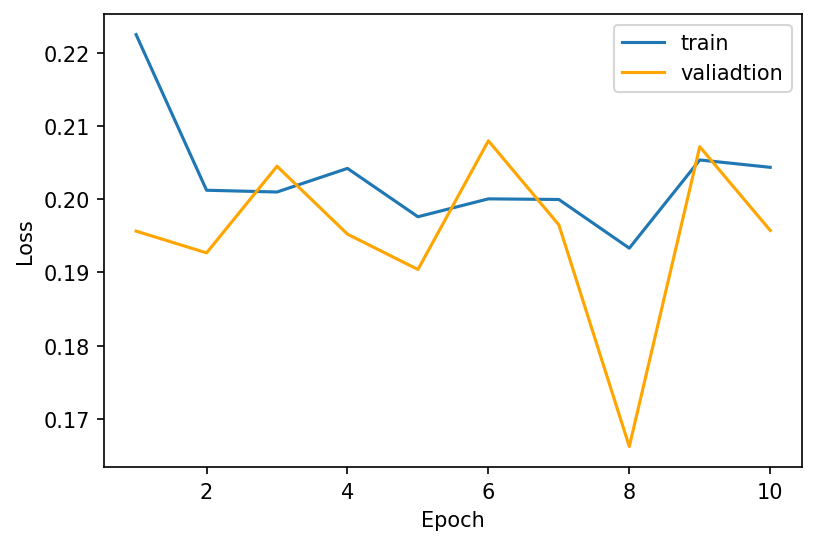

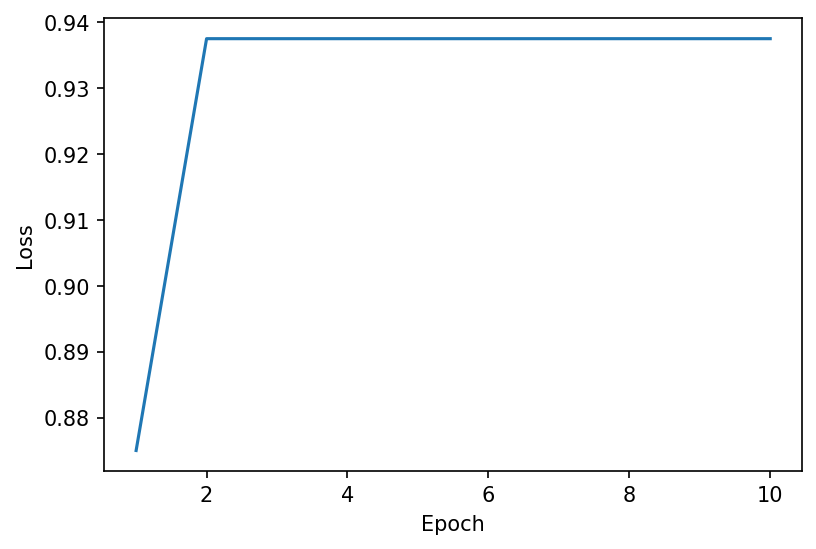

Validation loss is minimum in Epoch 8: Test set accuracy (precision@1) = 0.9375


In [17]:
import os
from contextlib import redirect_stdout, redirect_stderr
with redirect_stderr(open(os.devnull, 'w')):
    train_loss_list, val_loss_list, test_accuracy_list, test_embeddings_list, test_labels_list = train(train_dataset, val_dataset, test_dataset)
output_result(train_loss_list, val_loss_list, test_accuracy_list)

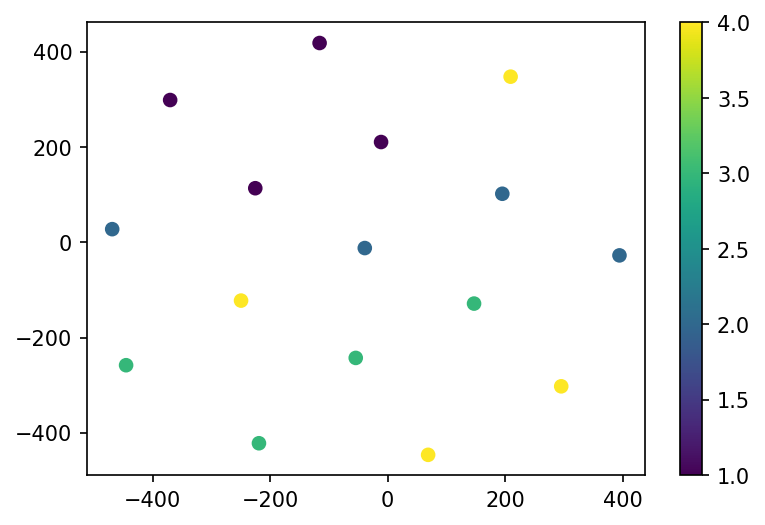

In [18]:
# visualization using tsne
from sklearn.manifold import TSNE

min_val_epoch = np.argmin(val_loss_list)
test_embeddings = test_embeddings_list[min_val_epoch]
test_labels = test_labels_list[min_val_epoch]

reduced_embeddings = TSNE(n_components=2, random_state=0).fit_transform(test_embeddings)
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=test_labels)
plt.colorbar()

Epoch 1: Loss = 0.22244973480701447
Validation Loss = 0.19564446806907654
Test set accuracy (Precision@1) = 0.875
Epoch 2: Loss = 0.20121927559375763
Validation Loss = 0.19267241656780243
Test set accuracy (Precision@1) = 0.9375
Epoch 3: Loss = 0.20097990334033966
Validation Loss = 0.20449532568454742
Test set accuracy (Precision@1) = 0.9375
Epoch 4: Loss = 0.20420101284980774
Validation Loss = 0.19522735476493835
Test set accuracy (Precision@1) = 0.9375
Epoch 5: Loss = 0.197602316737175
Validation Loss = 0.19040390849113464
Test set accuracy (Precision@1) = 0.9375
Epoch 6: Loss = 0.20004363358020782
Validation Loss = 0.20796926319599152
Test set accuracy (Precision@1) = 0.9375
Epoch 7: Loss = 0.19995947182178497
Validation Loss = 0.19649800658226013
Test set accuracy (Precision@1) = 0.9375
Epoch 8: Loss = 0.1933148205280304
Validation Loss = 0.16625085473060608
Test set accuracy (Precision@1) = 0.9375
Epoch 9: Loss = 0.20535115897655487
Validation Loss = 0.2071620225906372
Test set ac

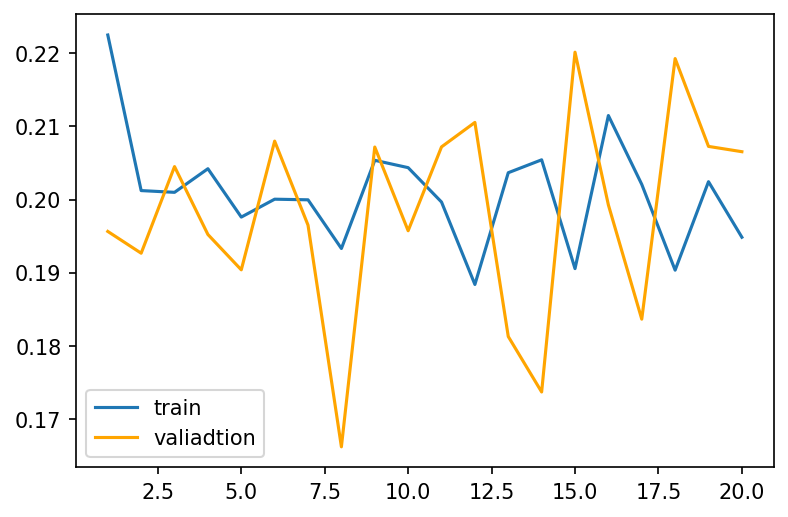

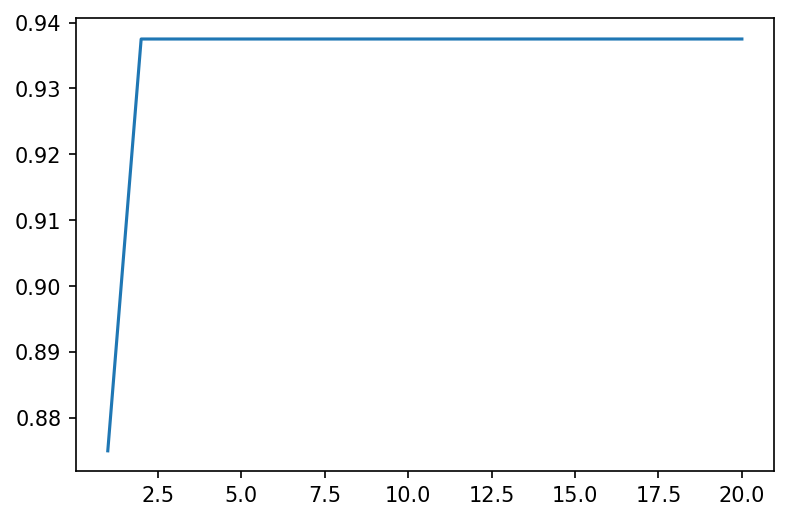

Validation loss is minimum in Epoch 7: Test set accuracy (precision@1) = 0.9375


In [ ]:
num_epochs = 20
with redirect_stderr(open(os.devnull, 'w')):
    train_loss_list, val_loss_list, test_accuracy_list, _, _ = train(train_dataset, val_dataset, test_dataset, num_epochs=num_epochs)
output_result(train_loss_list, val_loss_list, test_accuracy_list)

Epoch 1: Loss = 0.19900007545948029
Validation Loss = 0.20621290802955627
Test set accuracy (Precision@1) = 0.9375
Epoch 2: Loss = 0.19566306471824646
Validation Loss = 0.1618797481060028
Test set accuracy (Precision@1) = 0.875
Epoch 3: Loss = 0.2364327609539032
Validation Loss = 0.22067470848560333
Test set accuracy (Precision@1) = 0.9375
Epoch 4: Loss = 0.20632708072662354
Validation Loss = 0.18675309419631958
Test set accuracy (Precision@1) = 0.9375
Epoch 5: Loss = 0.20403854548931122
Validation Loss = 0.19852948188781738
Test set accuracy (Precision@1) = 0.9375
Epoch 6: Loss = 0.19937169551849365
Validation Loss = 0.20889367163181305
Test set accuracy (Precision@1) = 0.9375
Epoch 7: Loss = 0.1896822154521942
Validation Loss = 0.2050384283065796
Test set accuracy (Precision@1) = 0.9375
Epoch 8: Loss = 0.19120173156261444
Validation Loss = 0.19776955246925354
Test set accuracy (Precision@1) = 0.9375
Epoch 9: Loss = 0.19759604334831238
Validation Loss = 0.19464972615242004
Test set ac

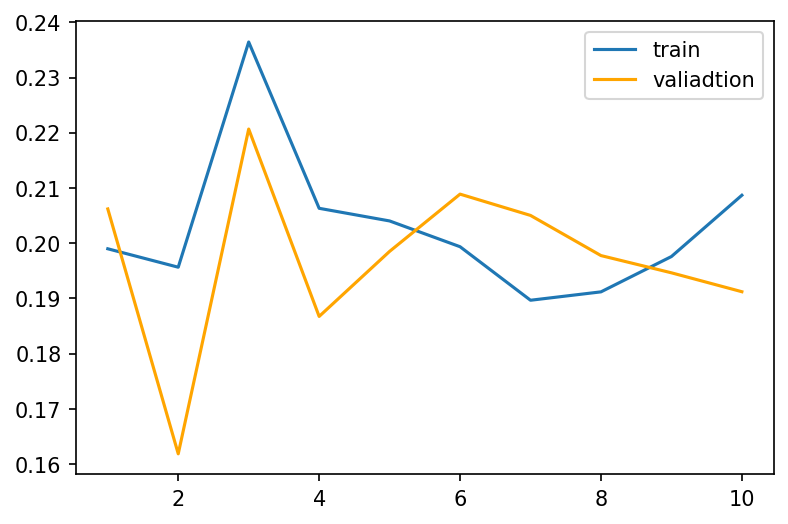

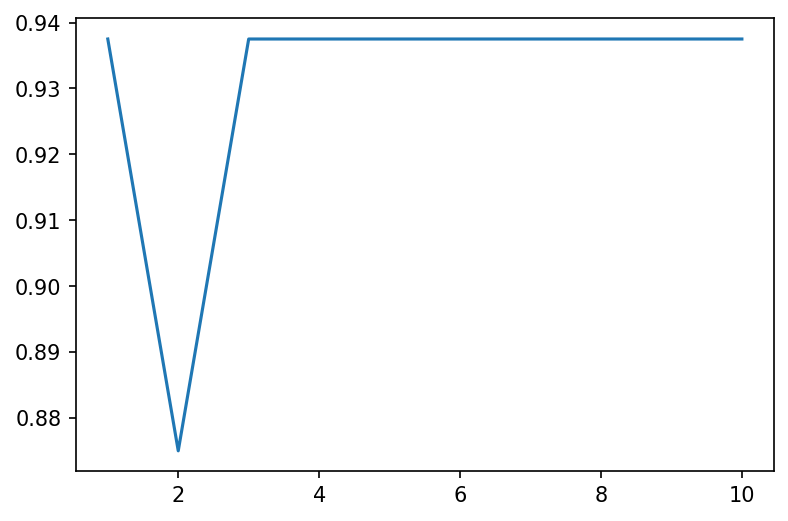

Validation loss is minimum in Epoch 1: Test set accuracy (precision@1) = 0.875


In [ ]:
# change the model size
model = 'Net()'
with redirect_stderr(open(os.devnull, 'w')):
    train_loss_list, val_loss_list, test_accuracy_list, _, _ = train(train_dataset, val_dataset, test_dataset, model_size=model)
output_result(train_loss_list, val_loss_list, test_accuracy_list)

Epoch 1: Loss = 0.21516112983226776
Validation Loss = 0.19602730870246887
Test set accuracy (Precision@1) = 0.875
Epoch 2: Loss = 0.20123004913330078
Validation Loss = 0.18823501467704773
Test set accuracy (Precision@1) = 0.8125
Epoch 3: Loss = 0.22449032962322235
Validation Loss = 0.20530802011489868
Test set accuracy (Precision@1) = 0.9375
Epoch 4: Loss = 0.21755759418010712
Validation Loss = 0.17935168743133545
Test set accuracy (Precision@1) = 0.875
Epoch 5: Loss = 0.19703900814056396
Validation Loss = 0.18432623147964478
Test set accuracy (Precision@1) = 0.875
Epoch 6: Loss = 0.20088982582092285
Validation Loss = 0.20366835594177246
Test set accuracy (Precision@1) = 0.9375
Epoch 7: Loss = 0.20135967433452606
Validation Loss = 0.19738814234733582
Test set accuracy (Precision@1) = 0.9375
Epoch 8: Loss = 0.19269032776355743
Validation Loss = 0.19311967492103577
Test set accuracy (Precision@1) = 0.875
Epoch 9: Loss = 0.20111918449401855
Validation Loss = 0.2066919505596161
Test set ac

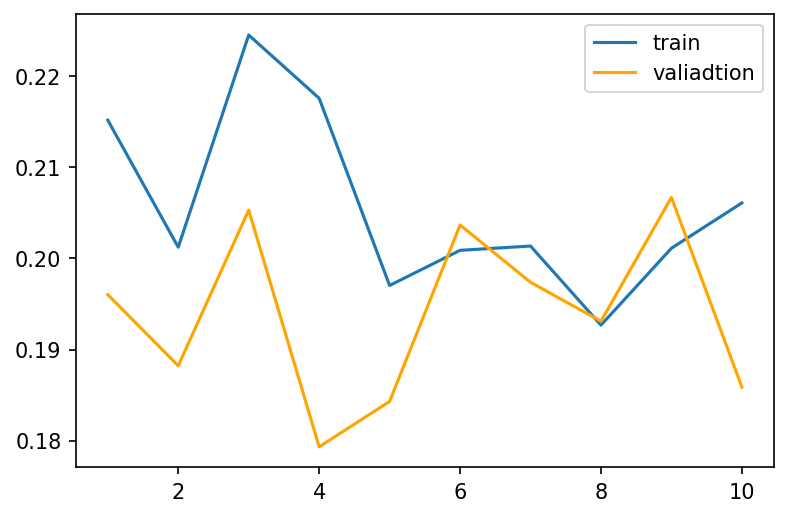

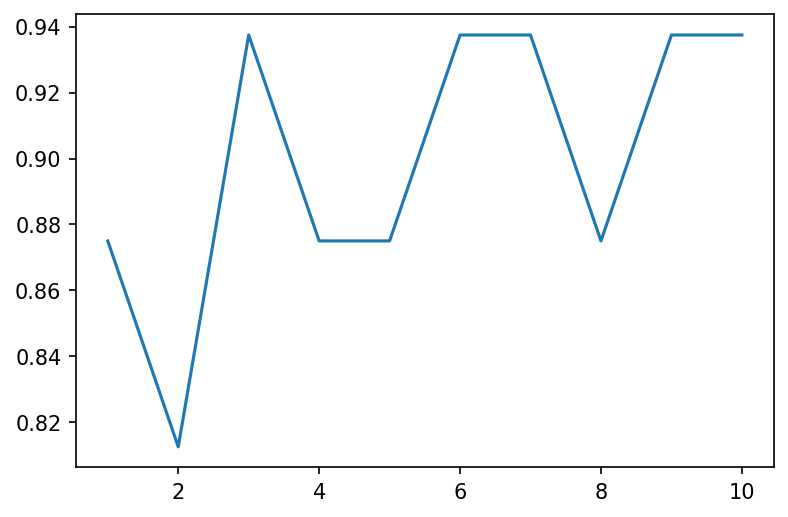

Validation loss is minimum in Epoch 3: Test set accuracy (precision@1) = 0.875


In [ ]:
# change the learning rate
lr = 0.01
with redirect_stderr(open(os.devnull, 'w')):
    train_loss_list, val_loss_list, test_accuracy_list, _, _ = train(train_dataset, val_dataset, test_dataset, lr=lr)
output_result(train_loss_list, val_loss_list, test_accuracy_list)

## reduce the amount of the training dataset

In [ ]:
def reduce_train(reduced_rate, seed=7):
    torch.manual_seed(seed)
    if reduced_rate < 1:
        len_reduced_train = int(len(train_dataset) * reduced_rate)
        len_rest = len(train_dataset) - len_reduced_train
        reduced_train_dataset, _ = torch.utils.data.random_split(train_dataset, [len_reduced_train, len_rest])
    else:
        reduced_train_dataset = train_dataset
    with redirect_stderr(open(os.devnull, 'w')):
        train_loss_list, val_loss_list, test_accuracy_list, _, _ = train(reduced_train_dataset, val_dataset, test_dataset)
    # output_result(train_loss_list, val_loss_list, test_accuracy_list)
    min_val_loss_epoch = np.argmin(val_loss_list)
    test_acc = test_accuracy_list[min_val_loss_epoch]['precision_at_1']
    return test_acc

In [ ]:
reduced_rate_list = [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]
acc_list = []
for rate in reduced_rate_list:
    with redirect_stdout(open(os.devnull, 'w')):
        acc = reduce_train(rate)
    print('reduced rate: {}, test set accuracy : {}'.format(rate, acc))
    acc_list.append(acc)

reduced rate: 0.125, test set accuracy : 0.75
reduced rate: 0.25, test set accuracy : 0.8125
reduced rate: 0.375, test set accuracy : 0.875
reduced rate: 0.5, test set accuracy : 0.9375
reduced rate: 0.625, test set accuracy : 0.9375
reduced rate: 0.75, test set accuracy : 0.9375
reduced rate: 0.875, test set accuracy : 0.9375
reduced rate: 1, test set accuracy : 0.9375


Text(0, 0.5, 'Precision')

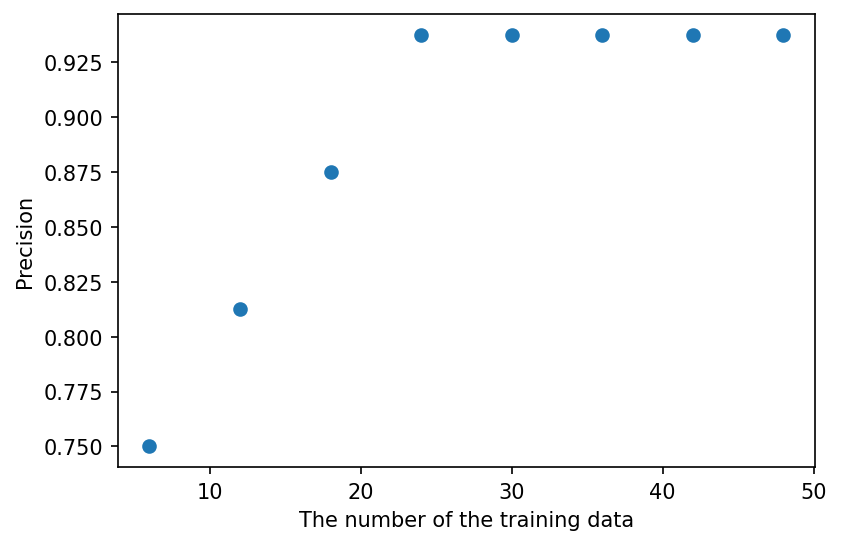

In [ ]:
plt.scatter([rate * len(train_dataset) for rate in reduced_rate_list], acc_list)
plt.xlabel('The number of the training data')
plt.ylabel('Precision')